# Weather Forecast

### Using time-series data

### Problem Definition

Predict weather forecast based on the date-time provided. Our model provides prediction regarding: <ol><br>
    <li>Humidity
    <li>Wind Speed
    <li>Mean Temperature
    <li>Mean Pressure

### Data

Data provided publicly on Kaggle.

### Evaluation 
Trained on k-nearest-neighbors.

Our model will be evaluated on Coefficient of determination (r2_score)metric which is the proportion of the variation in the dependent variable that is predictable from the independent variable.<br>
r2_score will be used to assess the accuracy of our predictions from the date-time column.

### Importing libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', 100)
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")
from plotly.subplots import make_subplots
import plotly.graph_objs as go

#### Training and Testing Data

In [97]:
train = pd.read_csv("DailyDelhiClimateTrain.csv")
test = pd.read_csv("DailyDelhiClimateTest.csv")

##### Change date into datetime format

In [98]:
compiled_data = pd.concat((train, test), ignore_index=True) 
compiled_data['date'] = pd.to_datetime(compiled_data['date']) # making the data in datetime format.
compiled_data = compiled_data.sort_values(by=['date']) # sorting by date.

In [99]:
compiled_data.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.00,84.50,0.00,1015.67
1,2013-01-02,7.40,92.00,2.98,1017.80
2,2013-01-03,7.17,87.00,4.63,1018.67
3,2013-01-04,8.67,71.33,1.23,1017.17
4,2013-01-05,6.00,86.83,3.70,1016.50


In [100]:
compiled_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1576 entries, 0 to 1575
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1576 non-null   datetime64[ns]
 1   meantemp      1576 non-null   float64       
 2   humidity      1576 non-null   float64       
 3   wind_speed    1576 non-null   float64       
 4   meanpressure  1576 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 73.9 KB


##### Now our date column data-type is datetime64 

### Plotting the data

In [107]:
fig = make_subplots(rows=4, cols=1,
                    vertical_spacing=0.1,
                    subplot_titles=('meantemp', 'humidity',
                                    "wind_speed" ,'meanpressure'))

fig.append_trace(go.Scatter(x=compiled_data['date'], y=compiled_data['meantemp']),
              row=1, col=1)

fig.add_trace(go.Scatter(x=compiled_data['date'], y=compiled_data['humidity']),
              row=2, col=1)

fig.add_trace(go.Scatter(x=compiled_data['date'], y=compiled_data['wind_speed']),
              row=3, col=1)

fig.add_trace(go.Scatter(x=compiled_data['date'], y=compiled_data['meanpressure']),
              row=4, col=1)

fig.update_layout(height=1600,showlegend=False)
fig.show()

### Correlation Matrix

<AxesSubplot:>

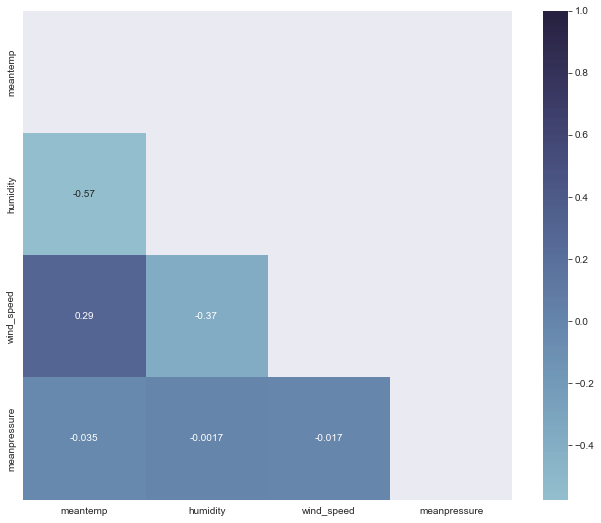

In [106]:
corr = compiled_data.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot = corr,
            square=True,vmax=1)

#### Helper function for removing the outliers

In [57]:
def remove_outliers(column):
    Q1 = column.quantile(.25)
    Q3 = column.quantile(.75)
    IQR = Q3 - Q1
    column = column[((Q1 - 1.5 * IQR) <= column) & (column  <= (Q3 + 1.5 * IQR))]
    return column

### Splitting Data into Train and Test 

In [111]:
compiled_data['year'] = compiled_data.ds.dt.year # making year column.
compiled_data['month'] = compiled_data.ds.dt.month # making month column.
compiled_data['monthday'] = compiled_data.ds.dt.day # making day of month column.
compiled_data['yearday'] = compiled_data.ds.dt.dayofyear # making day of year column.

In [112]:
compiled_data.rename(columns={'date':'ds'},inplace=True) # changing the date column name to "ds" for NeuralProphet model.
for col in ["wind_speed" ,'meanpressure']:  
    compiled_data[col] = remove_outliers(compiled_data[col]) # removing the column's outliers
compiled_data.dropna(inplace=True)
# spliting the data back to train and test data.
train = compiled_data.iloc[:len(train),:]
test = compiled_data.iloc[len(train):,:] 

##### We will be plotting weather parameters with date-time

In [113]:
fig = make_subplots(rows=2, cols=1,
                    vertical_spacing=0.1,
                    subplot_titles=("wind_speed" ,'meanpressure'))

fig.add_trace(go.Scatter(x=compiled_data['ds'], y=compiled_data['wind_speed']),
              row=1, col=1)

fig.add_trace(go.Scatter(x=compiled_data['ds'], y=compiled_data['meanpressure']),
              row=2, col=1)

fig.update_layout(height=800,showlegend=False)
fig.show()

Now it's modeling time, using:
KNeighbors algorithm to try to predict all the test data only by it's date data.

In [114]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

KNNforecasts = dict()

for column in ['meantemp','humidity','wind_speed','meanpressure']:
    
    m = KNeighborsRegressor(n_neighbors=27)
    X = train[['year','month','monthday','yearday']]
    y = train[column]
    model = m.fit(X,y)
    X_test = test[['year','month','monthday','yearday']]
    forecast = m.predict(X_test)
    KNNforecasts[column] = forecast
    print(f'r2 score for {column} : {r2_score(test[column],forecast)}')


r2 score for meantemp : 0.7246084864717337
r2 score for humidity : -0.038299329496336965
r2 score for wind_speed : -0.11935662489059595
r2 score for meanpressure : 0.2898964021365682


Plotting our models forecast with the training set target.

In [115]:
fig = make_subplots(rows=4, cols=1, vertical_spacing=0.08,subplot_titles=('meantemp', 'humidity',
                                    "wind_speed" ,'meanpressure'))

row = 1
for col,fcst in KNNforecasts.items():
    
    fig.append_trace(go.Scatter(x=test['ds'], y=test[col],name=col),
              row=row, col=1)
    fig.append_trace(go.Scatter(x=test['ds'], y=fcst, name = col+' forecast'),
              row=row, col=1)
    row +=1
fig.update_layout(height=1600)
fig.show()

Making the the same algorithm predict the target for test-data parameter

In [72]:
from sklearn.neighbors import KNeighborsRegressor

KNNforecasts = dict()

for column in ['meantemp','humidity','wind_speed','meanpressure']:
    
    m = KNeighborsRegressor(n_neighbors=27)
    X = train.drop(['ds',column],axis = 1)
    y = train[column]
    model = m.fit(X,y)
    X_test = test.drop(['ds',column],axis = 1)
    forecast = m.predict(X_test)
    KNNforecasts[column] = forecast
    print(f'r2 score for {column} : {r2_score(test[column],forecast)}')

r2 score for meantemp : 0.788603433535022
r2 score for humidity : 0.19744456248221431
r2 score for wind_speed : 0.0538139649829803
r2 score for meanpressure : 0.5176042636922933


Now we can compare the results visually by plotting the test data with predictions generated from our model. 

In [74]:
fig = make_subplots(rows=4, cols=1, vertical_spacing=0.08,subplot_titles=('meantemp', 'humidity',
                                    "wind_speed" ,'meanpressure'))

row = 1
for col,fcst in KNNforecasts.items():
    
    fig.append_trace(go.Scatter(x=test['ds'], y=test[col],name=col),
              row=row, col=1)
    fig.append_trace(go.Scatter(x=test['ds'], y=fcst, name = col+' forecast'),
              row=row, col=1)
    row +=1
fig.update_layout(height=1600)
fig.show()

Clearly, we can see improvements. However, to imporve our r2_score we may want to consider hyperparameter tuning or adopting other sklearn models on the dataset. 